## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('./data/ab_data.csv')
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


b. Use the below cell to find the number of rows in the dataset.

In [3]:
len(df)

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")')['user_id'].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id**s repeated in **df2**. What is it?

In [11]:
duplicate_user = df2[df2['user_id'].duplicated()].user_id
duplicate_user

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates(subset='user_id', keep='first', inplace=False)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control_df = df2.query('group == "control"')
control_conversion = control_df['converted'].mean()
control_conversion

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment_df = df2.query('group == "treatment"')
treatment_conversion = treatment_df['converted'].mean()
treatment_conversion

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
new_page_df = df2.query('landing_page == "new_page"')
len(new_page_df) / len(df2)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

In [18]:
obs_diff = treatment_conversion - control_conversion
obs_diff

-0.0015782389853555567

**Given that the conversion rate the control is `12.0%` and experiment is `11.9%`, there is no sufficient evidence that the treatment page leads to more conversions as the control group is slightly higher.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

-  **Hypothesis**

  $$H_0: p_{new} \leq p_{old}$$
  
  $$H_1: p_{new} > p_{old}$$

-  **In other words**

  $$H_0: p_{new} - p_{old} \leq 0$$

  $$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].sum() / len(df2)
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].sum() / len(df2)
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
new_page_df = df2.query('landing_page == "new_page"')
n_new = new_page_df.shape[0]
n_new

145310

d. What is $n_{old}$?

In [22]:
old_page_df = df2.query('landing_page == "old_page"')
n_old = old_page_df.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
treatment_df = df2.query('group == "treatment"')
sample_new = treatment_df.sample(n_new, replace=True)
new_page_converted = sample_new['converted']
new_page_converted.mean() 

0.1182437547312642

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
control_df = df2.query('group == "control"')
sample_old = control_df.sample(n_old, replace=True)
old_page_converted = sample_old['converted']
old_page_converted.mean()

0.11953274501975578

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
# this is a result of one simulation.
# the simulation need to be repeated many times (bootstrap) to enable hypothesis testing
p_diff_simulate = new_page_converted.mean() - old_page_converted.mean()
p_diff_simulate

-0.0012889902884915816

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
# bootstraping to get sampling distribution for the conversion differences
treatment_conv_prob = []
control_conv_prob = []
p_diffs = []

for _ in range(10000):
    sample_new2 = treatment_df.sample(n_new, replace=True)
    sample_old2= control_df.sample(n_old, replace=True)
    
    treatment_conversion = sample_new2['converted'].mean()
    control_conversion = sample_old2['converted'].mean()
    
    treatment_conv_prob.append(treatment_conversion)
    control_conv_prob.append(control_conversion)
    p_diffs.append(treatment_conversion - control_conversion)
    
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

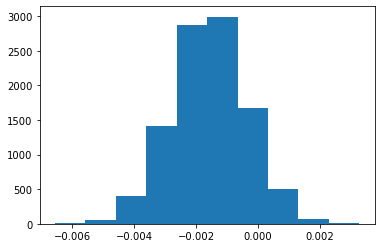

In [27]:
# Let's take a look at our sampling distribution
plt.hist(p_diffs);

In [28]:
# we can compute the p-value for our statistic,
# the observed difference in proportions, by simulating the distribution under the null hypothesis and then
# finding the probability that our statistic came from that distribution. To simulate the null, we'll create a normal
# distribution centered at zero, with the same standard devation and size as our simulated sampling distribution
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

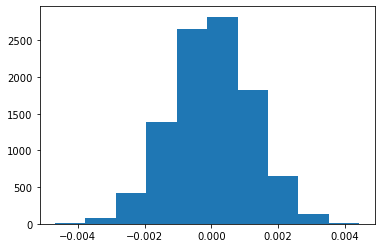

In [29]:
# which looks like this
plt.hist(null_vals);

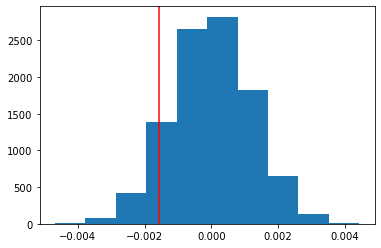

In [30]:
# And this is where our observed statistic falls
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
# proportion of the p_diffs greater than the actual difference observed is 50%
(p_diffs > obs_diff).mean()

0.5031

In [32]:
# We find the p-value like this
p_val = (null_vals > obs_diff).mean()
p_val

0.9066

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**
- The above red line is where our observed statistics fall, the value I just computed in part j is the `p-value`.
- With a p-value of `0.91`, we conclude the difference in conversion rate between new page and old page does not appear to be significant. We fail to reject the null hypothesis concluding new page is not better than old page.
-  The actual difference between new page and old page is negative, suggesting old page may be slightly better.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

treatment_df = df2.query('group == "treatment"')
control_df = df2.query('group == "control"')

convert_new = len(treatment_df.query('converted == 1'))
convert_old = len(control_df.query('converted == 1'))
n_new = len(treatment_df)
n_old = len(control_df)
n_new, n_old

(145310, 145274)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
from statsmodels.stats.proportion import proportions_ztest

# the order is very important and has to follow our hypothesis
successes = np.array([convert_new, convert_old])
samples = np.array([n_new, n_old])

# we select the larger in the hypothesis attributes because that is our H1
stat, pval = proportions_ztest(count=successes, nobs=samples, alternative='larger')
stat, pval

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**

-  The z-score and p-value communicate the same message as part j and k, our p-value is very large which suggest our statistic is likely to come from the null hypothesis. 
-  Hence, we fail to reject the null hypothesis and conclude that new page is not better than old page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

### Answer
**Logistics Regression.** Since we are to predict only two possible outcomes.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [36]:
# add intercept
df2['intercept'] = 1

#Add dummies and rename treatment column as ab_page
df2[['ab_page', 'control']] = pd.get_dummies(df['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,control
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
import statsmodels.api as sm

y = df2['converted']
x = df2[['intercept', 'ab_page']]

# load model
logit_mod = sm.Logit(y, x)

# fit model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
# model summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 May 2022   Pseudo R-squ.:               8.077e-06
Time:                        06:30:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**To interprete Logistic Regression, we first exponentiate the variables coefficient.**

In [39]:
# exponentiate the variables coefficient
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

**With returned values less than 1. it is often beneficial to obtain the reciprocal.**
**`NOTE` mostly applies to negative coefficient.**

In [40]:
print("ab_page reciprocal exponential: ", 1/np.exp(-0.0150), "-", "A conversion is 1.015 times less likely, if a user receives the treatment page")

ab_page reciprocal exponential:  1.015113064615719 - A conversion is 1.015 times less likely, if a user receives the treatment page


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

-  **Hypothesis**

  $$H_0: p_{new} \leq p_{old}$$

  $$H_1: p_{new} > p_{old}$$

-  **In other words**

  $$H_0: p_{new} - p_{old} \leq 0$$

  $$H_1: p_{new} - p_{old} > 0$$


**Answer**
* The p-value associated with ab_page is 0.190.*
* The p-value differ from the value found in **part II** beacuse Logistic Regression have different way of interpreting it parameters from the summary table.

**Note that the predictor is ab_page which means that the  regression model turned our binary predictor (Group) into dummy variable which takes the value of `1` for `treatment` and `0` for `control`.**   

* The results summary shows that the estimated coefficient for our predictor is negative in both models(intercept & ab_page), indicating that user who received the new page has a lower conversion rate than those who received the old page.
* However, the p-value of the coefficient is `0.190` which is above our `0.05` threshold, meaning we fail to reject our null hypothesis.
(https://towardsdatascience.com/embracing-bayesian-a-b-test-measurement-and-ditching-p-values-9e444df379ca)
* Based on that p_value we can say, that the conversion is not significant dependent on the page. 


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer.**

-  We should consider other factors into the regression model as they might influence the conversions too. For instance student segments [new v/s returning candidates] might create change aversion or even, the opposite as a predisposition to conversion. Seasonality like new terms or New years might mean more interest in new skills/ resolutions. Timestamps are inlcuded but without regionality, they do not indicate if seasonality was a factor or not. [as different countries follow different term and weather patterns.
-  Factors like device on which tests were taken or course which was looked at, prior academic background, age, might alter experience and ultimately, conversions. These are limitations which should be at least kept in mind while making the final decision.
-  The disadvantages to adding additional terms into the regression model is that even with additional factors we can never account for all influencing factors or accomodate them. Plus, small pilots and pivots sometimes work better in practice than long-drawn research without execution.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [42]:
countries_df = pd.read_csv('./data/countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [43]:
### Create the necessary dummy variables

# Add dummies and rename treatment column as ab_page
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,control,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [44]:
import statsmodels.api as sm

# set one of the variable as baseline(US).
y = df_new['converted']
x = df_new[['intercept', 'ab_page', 'CA', 'UK']]

# load model
logit_mod = sm.Logit(y, x)

# fit model
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 11 May 2022   Pseudo R-squ.:               2.323e-05
Time:                        06:30:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

* Base on the country variables p-value, we can say that these variables doesn't have impact on conversion rate. That is, there is no relationship between these variables and conversion rate.

In [45]:
print("ab_page reciprocal exponential: ", 1/np.exp(-0.0149), "-", "A conversion is 1.015 times less likely, if a user receives the treatment page, holding all other variables constant.\n"
      "\nCA reciprocal exponential: ", 1/np.exp(-0.0408), "-", "A conversion is 1.042 times less likely, if the user lives in CA and not the US.\n"
      "\nUK exponential: ",np.exp(0.0099),"-", "A conversion is 1.00995 times more likely, if the user lives in UK and not the US.")

ab_page reciprocal exponential:  1.0150115583846535 - A conversion is 1.015 times less likely, if a user receives the treatment page, holding all other variables constant.

CA reciprocal exponential:  1.0416437559600236 - A conversion is 1.042 times less likely, if the user lives in CA and not the US.

UK exponential:  1.0099491671175422 - A conversion is 1.00995 times more likely, if the user lives in UK and not the US.


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,control,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [47]:
#create the interaction higher order term for the ab_page and country columns
df_new['CA_page'], df_new['UK_page'] = df_new['CA'] * df_new['ab_page'], df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,control,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,0,1


In [48]:
import statsmodels.api as sm

# set one of the variable as baseline(US).
y = df_new['converted']
x = df_new[['intercept', 'ab_page', 'CA', 'UK', 'CA_page', 'UK_page']]

# load model
logit_mod = sm.Logit(y, x)

# fit model
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 11 May 2022   Pseudo R-squ.:               3.482e-05
Time:                        06:30:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

Based on these results, we can see that the p_values for the interaction terms are definietly not significant and even decrease the significance of the original "CA" and "UK" columns. Therefore we should not include these higher order terms in our model.

### Conclusions
-  The performance of the old page was found better (by very small values only) as computed by different techniques.
-  Hence, we failed to reject the Null Hypothesis.
These inferences are strictly based on data on hand. This analysis acknowledges its limitation due to factors not included in the data.

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.